<a href="https://colab.research.google.com/github/sir-sauc3/Project2/blob/main/Trial_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROJECT 2: DEER PARK
## Authors: Sos & Roberto



\

##Introduction:

Deer Park is a simulation project that tests self-regulating systems through a hypothetical field where deer are allowed to graze within certain parameters. The aim of the project is to identify the steady state of the system within a specific number of time steps. This project studies the behavior of ecosystems and their ability to self-regulate. By creating a controlled environment where we can observe the interactions between deer and their environment, we hope to gain insights into the dynamics of natural systems and apply them to real-world scenarios.


\


---



####The first cell imports the necesary modules

In [1]:
import numpy as np
from dataclasses import dataclass
from pprint import pprint
import random
from scipy.signal import correlate2d
import timeit
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.colors as colors

####The next two cells are the ones taken from previous labs that helped us when it came to visualizing the simulation during a run

In [2]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [39]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(9, 9)): #frames=50, steps_per_frame=1, figsize=(8, 8)
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=0.4):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

##**Deer class**
We kept the deer class pretty simple. Including a few attributes and only having one method.

\
Using the modulus function `%` was a really neat and concise way to get the cardinal neighbours of a cell especially if the said neighbour was wrapped around the field. It saved us time and space from writing long conditional code blocks that adjusted indexing to make sure the positions returned match a true location on the grid.

In [4]:
class Deer:

  def __init__(self, location, weight=30, **grid_size):
    self.location = tuple(location)
    self.weight = weight
    self.gridsize= grid_size['grid_size']

  def cardinal_neighbors(self):
    x = self.location[0]
    y = self.location[1]
    return [((x-1)%self.gridsize, y), (x, (y+1)%self.gridsize), ((x+1)%self.gridsize, y), (x, (y-1)%self.gridsize)]

##**Grazing Simulation class**
This part of the notebook defines the grassland and the parameters that bound it. In it, we initialize some parameters like `regrowth_rate`, `max_weight`, `metabolism`,  and  `regrowth_interval` which indicates how many time steps should pass before regenerating the grass.


\
###Introducing N deer onto the grassland
There are a lot of ways we tried introducing and displaying the deer on the grassland. Most of which restricted the w:ay we could run tests on the simulation. However, the one coded in the cell below proved to be our best result. This is how the algorithm works:



*   Start by making a list of all possible locations on the grassland.
*   Shuffle them.
*   Choose the first N locations in the list and create a deer object in those positions.


\
###Moving the deer
Initially we had the deer move in random cardinal directions. But after running the simulaiton, it was clear that it did not seem realistic at all. That's because a lot of deer would starve to death moving back and forth between 'dry' cells even though there were cells with food not too far away. We needed a way to make them 'smart' so that there could be a purpose in the direcition they decided to take in the next time step.

We did this by making a `calculate_weights` method that returned the weights of the cardinal neighbours of the cell a deer was on. This allowed it to 'see' what cell was the next best one to move to.:





In [41]:
class Grazing_simulation:


  cmap = [(1, 0.5, 0), (0, 1, 0)]
  grazing_colour_map = matplotlib.colors.ListedColormap(cmap)


  def __init__(self, size, coverage, num_deer, regrowth_rate=0.25, max_weight=50, metabolism=10, regrowth_interval=5):
      self.size = size
      self.coverage = coverage
      self.num_deer = num_deer
      self.regrowth_rate = regrowth_rate
      self.max_weight = max_weight
      self.metabolism = metabolism
      self.regrowth_interval = regrowth_interval
      self.step_count = 0

      self.grassland = np.random.choice([1,0], (size,size), p=(coverage, 1-coverage))
      self.introduce_deer()

  def calculate_weights(self, deer):
      weights = []
      for neighbor in deer.cardinal_neighbors():
          x, y = neighbor
          if self.grassland[y][x] == 1:
              weight = 1
          else:
              weight = 0
          weights.append(weight)
      return weights


  def introduce_deer(self):
      locs = [(x,y) for x in range(self.size) for y in range(self.size)]
      np.random.shuffle(locs)

      assert(self.num_deer <= len(locs))
      self.deers = [Deer(locs[i], grid_size = self.size) for i in range(self.num_deer)]


  def move_deer(self, deer):      
    weights = self.calculate_weights(deer)
    max_weight = max(weights)
    best_neighbors = [i for i, w in enumerate(weights) if w == max_weight]
    available_to_move = [(x,y) for i, (x,y) in enumerate(deer.cardinal_neighbors()) if i in best_neighbors and (x,y) not in self.occupied_locations]

    if (len(available_to_move) > 0):
        self.occupied_locations.remove(deer.location)
        deer.location = random.choice(available_to_move)
        self.occupied_locations.append(deer.location)
    else:
        return

    x, y = deer.location
    if self.grassland[y][x] == 1:
      if deer.weight == self.max_weight:
        deer.weight -= self.metabolism #A POSSIBLE PARAMETER TO CHANGE FOR SUSTAINABILITY EXPERIMENT
      else:
        deer.weight += self.metabolism #A POSSIBLE PARAMETER TO CHANGE FOR SUSTAINABILITY EXPERIMENT
        self.grassland[y][x] = 0
    else:
        deer.weight -= self.metabolism #A POSSIBLE PARAMETER TO CHANGE FOR SUSTAINABILITY EXPERIMENT
        if deer.weight <= 0:
            self.deers.remove(deer)




  def step(self):
    self.occupied_locations = [deer.location for deer in self.deers]

    self.step_count += 1
    if self.step_count % self.regrowth_interval == 0:
      regrowth_mask = np.random.choice([0,1], (self.size,self.size), p=(1-self.regrowth_rate, self.regrowth_rate))
      self.grassland = np.clip(self.grassland + regrowth_mask, 0, 1)

    weight_at_location = {} # a dictionary that, when allowed to print on line 83-84, shows the deer's location and weight at each time step
    for deer in self.deers:
      self.move_deer(deer)
      xs, ys = deer.location
      weight_at_location.update({(xs,ys):int(deer.weight)}) #recorded in col,row
      points = plt.plot(xs, ys, '.', color='brown', markersize=10) #plotted in col,row
    # print(f'deer weights at each time step: {weight_at_location}')
    # print("---------------------------------------------------------------------------------------")


  def draw(self, axes=None, step=''):
      """Draws the CA cells using the forest colour map so values are coloured intuitively."""
      axes = axes or plt.axes
      title = f'Time:{step}\nNumber of deer present: {len(self.deers)}'
      plot_2D_array(self.grassland, axes=axes, title=title,
                    cmap=self.grazing_colour_map, vmin=0, vmax=len(self.grazing_colour_map.colors))
      
  def run_simulation(self, num_steps):
      times = []
      for i in range(num_steps):
          start_time = timeit.default_timer()
          self.step()
          end_time = timeit.default_timer()
          times.append(end_time - start_time)

      return times

##After creating those two classes, we had to test our simulation out!

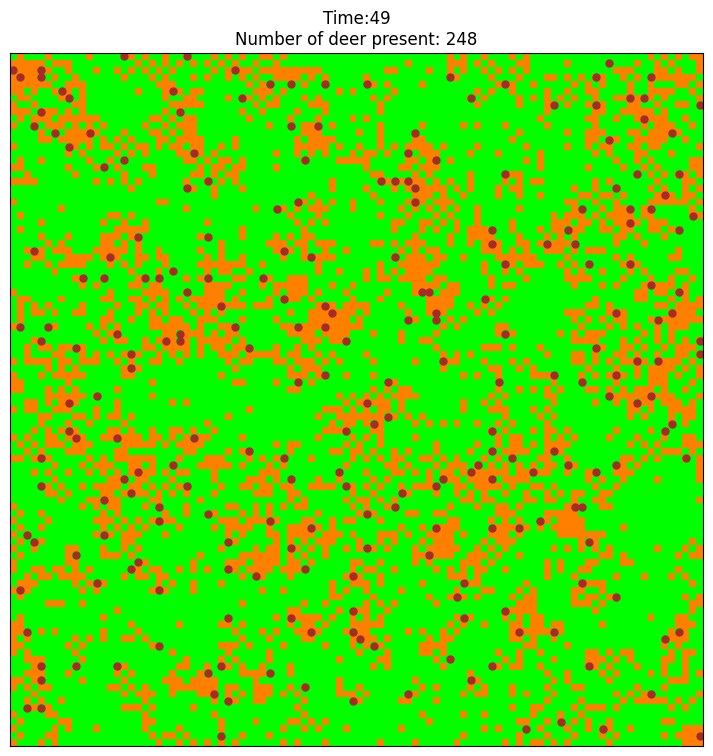

In [42]:
n=100
q=0.3
num_deer = 300

field = Grazing_simulation(n, q, num_deer)

run = Animation2D(field)
run.animate()

# Experiment Conclusion and Discussion

General observations about this system:
1. CHANGE - lines 57, 59, and 62 of the grazing simulation cell to make use of the metabolism parameter since that was a value we wanted to constatly change and measure sustainabilty

2. OBSERVATION - w/ metabolism at 9, weight gain = metabolism, and weight loss = metabolism, steady state was at time step 34 w/ about 282 deer (q=0.35)

3. OBSERVATION - w/ metabolism at 10, weight gain = metabolism, and weight loss = metabolism, steady state was at time step 35 w/ about 275 deer (q=0.35)

4. OBSERVATION - w/ metabolism at 10, weight gain = metabolism, and weight loss = metabolism, steady state was at time step 30 w/ about 250 deer (q=0.3)

The general results of this simplified deer grazing model tell us that the amount of deer and the amount of grass must be balanced to create a sustainable ecosystem. The regrowth rate of grass and deer metabolism speed also play an important role, but this is not as easily modifiable in the real world. However, it is a very simple way to display the self-regulating nature of grazing systems!

If given more time, we would've liked to incorporate maybe social groups like herds and had those herds travel together, or maybe water cells which kept the deer at the same weight rather than losing/gaining weight. Maybe even the inclusion of predators such as lions or cheetas to kill the smallest or random deer.

# Algorithm Analysis
1. The introduce_deer method has a time complexity of O(n^2) because it loops through all the cells in the grid to create a list of available locations to place the deer, and then shuffles that list before selecting the first m items to create the deer. The step method has a time complexity of O(m\*n) because it loops through all the deer and their cardinal neighbors to move the deer. This could result in up to a O(n\*n), should the inputs result in deer occupying every cell (this is an edge case however, not the average case).

This means that the model will continue to grow exponentially as the size of the CA increases. Thus, it's important to take note of how expensive running this simulation would be for longer CA experiments.

2. Refer to code block below. Code appears to support exponential growth analysis.

3. 

In [7]:
sim = Grazing_simulation(size=50, coverage=0.5, num_deer=10, regrowth_rate=0.25, max_weight=50, metabolism=3, regrowth_interval=5)
times = sim.run_simulation(num_steps=100)
print(f"Parameters: size:50, coverage: 50%, n Deer: 10, regrowth: 25%, max deer weight: 50, metabolism: 3, regrowth interval: 5, steps: 100")
print(f"Mean time per step: {sum(times)/len(times):.6f} seconds")

sim = Grazing_simulation(size=200, coverage=0.7, num_deer=10, regrowth_rate=0.25, max_weight=50, metabolism=3, regrowth_interval=5)
times = sim.run_simulation(num_steps=100)
print(f"Parameters: size:200, coverage: 70%, n Deer: 10, regrowth: 25%, max deer weight: 50, metabolism: 3, regrowth interval: 5, steps: 100")
print(f"Mean time per step: {sum(times)/len(times):.6f} seconds")

sim = Grazing_simulation(size=500, coverage=0.4, num_deer=300, regrowth_rate=0.25, max_weight=50, metabolism=10, regrowth_interval=5)
times = sim.run_simulation(num_steps=100)
print(f"Parameters: size:500, coverage: 40%, n Deer: 300, regrowth: 25%, max deer weight: 50, metabolism: 3, regrowth interval: 5, steps: 100")
print(f"Mean time per step: {sum(times)/len(times):.6f} seconds")

sim = Grazing_simulation(size=1000, coverage=0.4, num_deer=300, regrowth_rate=0.25, max_weight=50, metabolism=10, regrowth_interval=5)
times = sim.run_simulation(num_steps=100)
print(f"Parameters: size: 1000, coverage:40%, n Deer: 300, regrowth: 25%, max deer weight: 50, metabolism: 3, regrowth interval: 5, steps: 100")
print(f"Mean time per step: {sum(times)/len(times):.6f} seconds")

plt.clf() #hide deer plot

Parameters: size:50, coverage: 50%, n Deer: 10, regrowth: 25%, max deer weight: 50, metabolism: 3, regrowth interval: 5, steps: 100
Mean time per step: 0.006689 seconds
Parameters: size:200, coverage: 70%, n Deer: 10, regrowth: 25%, max deer weight: 50, metabolism: 3, regrowth interval: 5, steps: 100
Mean time per step: 0.008398 seconds
Parameters: size:500, coverage: 40%, n Deer: 300, regrowth: 25%, max deer weight: 50, metabolism: 3, regrowth interval: 5, steps: 100
Mean time per step: 0.261097 seconds
Parameters: size: 1000, coverage:40%, n Deer: 300, regrowth: 25%, max deer weight: 50, metabolism: 3, regrowth interval: 5, steps: 100
Mean time per step: 0.298697 seconds


<Figure size 640x480 with 0 Axes>